# Spatial modelling in R

This practical looks at some of the problems of fitting statistical models to spatial data, using the statistical software R. We are going to be covering a lot of ground but:

> Do **not** panic.

The intention in this practical is to show some options that are available for spatial models in R. The main thing is to think about what the options are available, not in learning how to do it all in one afternoon!

There are a lot of other resources out there to provide more detail and I *highly* recommend this:

[https://rspatial.org/raster/analysis/index.html](https://rspatial.org/raster/analysis/index.html)

## Required packages

As with species distribution mdelling, there are many packages used in spatial modelling. There is an intimidating complete list of topics and packages here:

[https://CRAN.R-project.org/view=Spatial](https://CRAN.R-project.org/view=Spatial)

This practical requires the following packages, which should all be installed in the RStudio Cloud project, but which you will need to install if you are using your own computer.

```r
install.packages('ncf')
install.packages('raster')
install.packages('sf')
install.packages('SpatialPack') # For clifford test
install.packages('spdep') # Spatial dependence
```

As usual, you then need to load the packages:

In [1]:
library(ncf)
library(raster)
library(sf)
library(spdep)
library(SpatialPack)

Loading required package: sp



Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



Loading required package: spData



To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



Loading required package: fastmatrix



## The dataset

We will use some data taken from a paper that looked at trying to predict what limits species ranges:

> McInnes, L., Purvis, A., & Orme, C. D. L. (2009). Where do species' geographic ranges stop and why? Landscape impermeability and the Afrotropical avifauna. Proceedings of the Royal Society Series B - Biological Sciences, 276(1670), 3063-3070. [http://doi.org/10.1098/rspb.2009.0656](http://doi.org/10.1098/rspb.2009.0656)

We won't actually be looking at range edges but we're going to use four variables taken from the data used in this paper. The data is all saved as GeoTIFF files, so we're starting with raster data. The files cover the Afrotropics and are all projected in the Behrmann equal area projection. This is a cylindrical equal area projection with a *latitude of true scale* of 30°. What that *means* is that distances on the projected map correspond to distances over the surface of the Earth at ±30° of latitude.

That is the reason for the odd resolution of this data: 96.268 km. The circumference of the Earth at ±30° - the length of the parallels at ±30° - is 34656.48 km and this resolution splits the map into 360 cells so the resolution is comparable to a degree longitude at 30° N. Unlike a one degree resolution grid, however, these grid cells all cover an equal area on the ground ($96.268 \times 96.268 = 9309.6 \text{km}^2$, roughly the land area of Cyprus).

The variables for each grid cell are:

* the avian species richness across the Afrotropics,
* the mean elevation,
* the average annual temperature, and
* the average annual actual evapotranspiration.

### Loading the data

In [2]:
# load the four variables from their TIFF files
rich <- raster('data/avian_richness.tif')
aet <- raster('data/mean_aet.tif')
temp <- raster('data/mean_temp.tif')
elev <- raster('data/elev.tif')

It is always a good idea to look at the details of the data. One key skills in being a good scientist and statistician is in looking at data and models and saying: 

> Uh, that doesn't make any sense, something has gone wrong.

So we will quickly use some techniques to explore the data we have just loaded. 

1. We will look at the summary of the richness data. That shows us the dimensions of the data, resolution, extent and coordinate reference system and the range of the data: between 10 and 667 species per cell (10,000 square kilometers).

In [3]:
# Look at the details of the richness data
print(rich)

class      : RasterLayer 
dimensions : 75, 78, 5850  (nrow, ncol, ncell)
resolution : 96.48627, 96.48627  (x, y)
extent     : -1736.753, 5789.176, -4245.396, 2991.074  (xmin, xmax, ymin, ymax)
crs        : +proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : /Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_3/data/avian_richness.tif 
names      : avian_richness 
values     : 10, 667  (min, max)



We can also plot maps the variables and think about the spatial patterns in each.

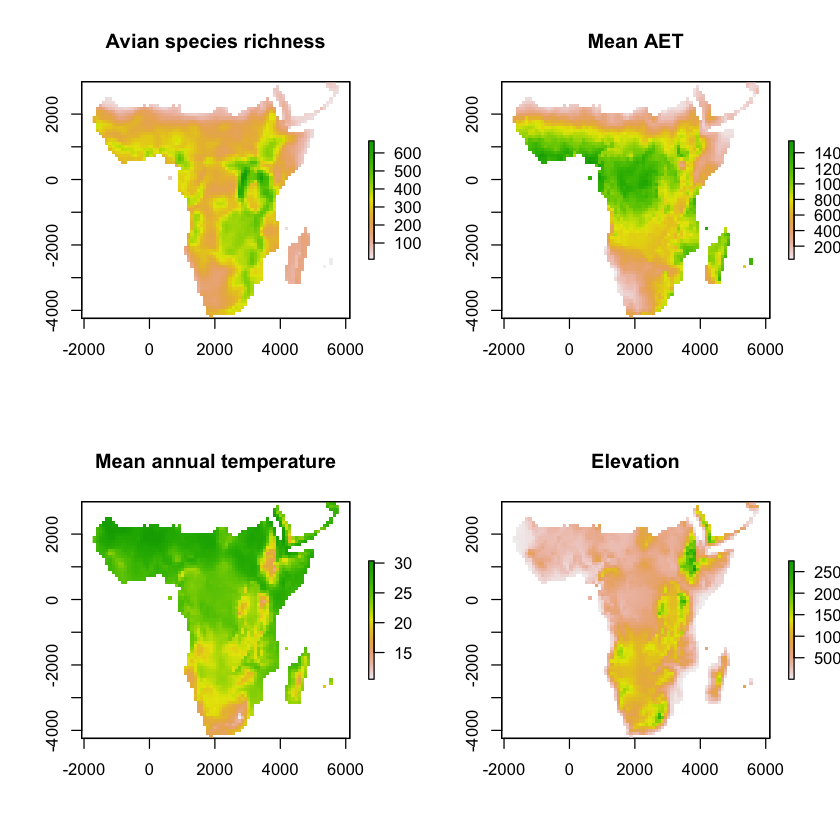

In [4]:
par(mfrow=c(2,2))
plot(rich, main='Avian species richness')
plot(aet, main='Mean AET')
plot(temp, main='Mean annual temperature')
plot(elev, main='Elevation')

We can use R to explore this data a bit further. We can use the `hist()` function to plot the distribution of the values in each variable, not just look at the minimum and maximum.

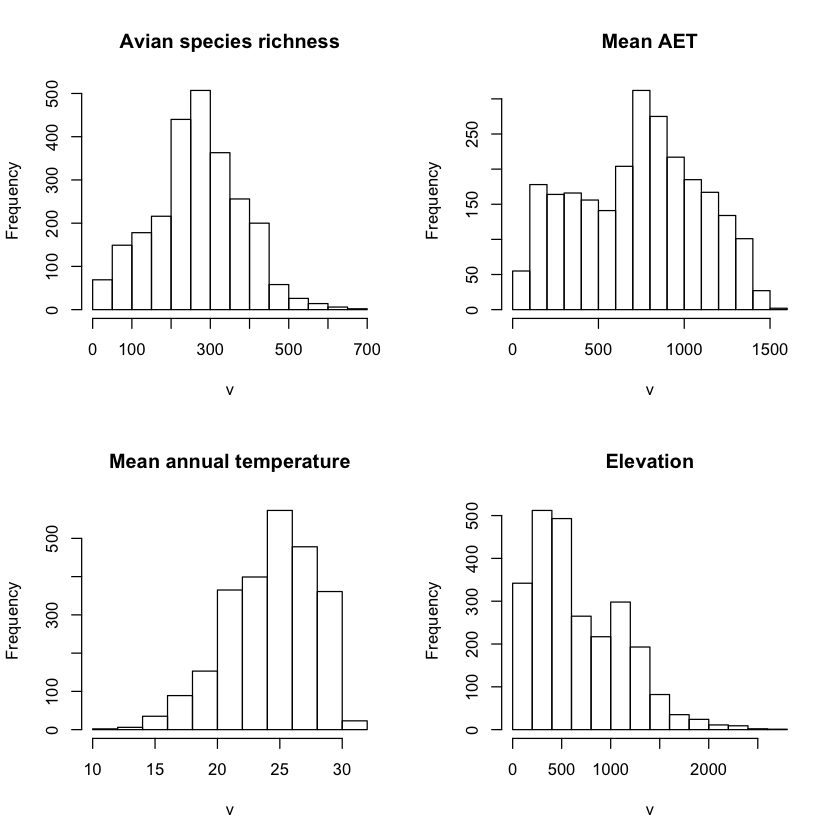

In [5]:
# split the figure area into a two by two layout
par(mfrow=c(2,2))
# plot a histogram of the values in each raster, setting nice 'main' titles
hist(rich, main='Avian species richness')
hist(aet, main='Mean AET')
hist(temp, main='Mean annual temperature')
hist(elev, main='Elevation')

### Formatting the data as a data frame 

We now have the data as rasters but some of the methods require the values in a data frame. We'll need to use two commands: 

First, `stack()` allows us to superimpose the four rasters into a single object. Note that this only works because all of these rasters have the same projection, extent and resolution. In your own use, you would need to use GIS to set up your data so it can be stacked like this.

In [6]:
# Stack the data
data_stack <- stack(rich, aet, elev, temp)
print(data_stack)

class      : RasterStack 
dimensions : 75, 78, 5850, 4  (nrow, ncol, ncell, nlayers)
resolution : 96.48627, 96.48627  (x, y)
extent     : -1736.753, 5789.176, -4245.396, 2991.074  (xmin, xmax, ymin, ymax)
crs        : +proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +ellps=WGS84 +towgs84=0,0,0 
names      : avian_richness,  mean_aet,      elev, mean_temp 
min values :        10.0000,   32.0600,    1.0000,   10.5246 
max values :       667.0000, 1552.6500, 2750.2800,   30.3667 



Second, `as()` allows us to convert an R object from one format to another. Here we convert to the `SpatialPixelDataFrame` format from the `sp` package. This is a useful format because it works very like a data frame, but identifies the geometry as pixels. Note that the names of the *variables in the data frame have been set from the original TIFF filenames*, not our variable names in R.

In [7]:
data_spdf <- as(data_stack, 'SpatialPixelsDataFrame')
summary(data_spdf)

Object of class SpatialPixelsDataFrame
Coordinates:
        min      max
x -1736.753 5789.176
y -4245.396 2991.074
Is projected: TRUE 
proj4string :
[+proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km
+no_defs +ellps=WGS84 +towgs84=0,0,0]
Number of points: 2484
Grid attributes:
   cellcentre.offset cellsize cells.dim
s1         -1688.510 96.48627        78
s2         -4197.153 96.48627        75
Data attributes:
 avian_richness     mean_aet            elev          mean_temp    
 Min.   : 10.0   Min.   :  32.06   Min.   :   1.0   Min.   :10.52  
 1st Qu.:202.0   1st Qu.: 439.70   1st Qu.: 317.7   1st Qu.:21.83  
 Median :269.5   Median : 754.59   Median : 548.8   Median :24.71  
 Mean   :268.4   Mean   : 732.07   Mean   : 672.0   Mean   :24.25  
 3rd Qu.:341.0   3rd Qu.: 996.60   3rd Qu.:1023.2   3rd Qu.:27.15  
 Max.   :667.0   Max.   :1552.65   Max.   :2750.3   Max.   :30.37  

We can also that into a `sf` object, which we have been using in previous practicals. These differ in how they represent the geometry:

* `SpatialPixelDataFrame`: this holds the data as values in *pixels*, so 'knows' that the values represents an area.
* `sf`: the conversion we use here holds the data as values at a point.

In [8]:
data_sf <- st_as_sf(data_spdf)
print(data_sf)

Simple feature collection with 2484 features and 4 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -1736.753 ymin: -4245.396 xmax: 5789.176 ymax: 2991.074
CRS:            +proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +ellps=WGS84 +towgs84=0,0,0
First 10 features:
   avian_richness mean_aet     elev mean_temp                  geometry
1              55 157.4988  619.990   25.5596 POINT (5451.474 2942.831)
2              52 117.5050  353.648   26.7782  POINT (5547.96 2942.831)
3              44  93.1765  270.054   27.3340 POINT (5644.447 2942.831)
4              45  86.4079 1043.670   24.9595 POINT (3907.694 2846.345)
5              38 136.8711  353.393   27.2728 POINT (5451.474 2846.345)
6              50  99.2078  773.086   24.9603  POINT (5547.96 2846.345)
7              49 110.1031  610.546   25.6667 POINT (5644.447 2846.345)
8              38 122.4231  820.173   25.0142 POINT (5740.933 2846.345)
9              58  70.4857  294.331 

### More data exploration

We now have new data structures that have spatial information and matches up the different variables across locations. 

We can still plot the data as a map and the images below show the difference between the `SpatialPixelsDataFrame` and the `sf` version of the data. The code has lots of odd options: this combination of settings avoids each plot command insisting on the layout it wants to use and lets us control the layout of the plots.

https://www.r-spatial.org/r/2016/03/08/plotting-spatial-grids.html

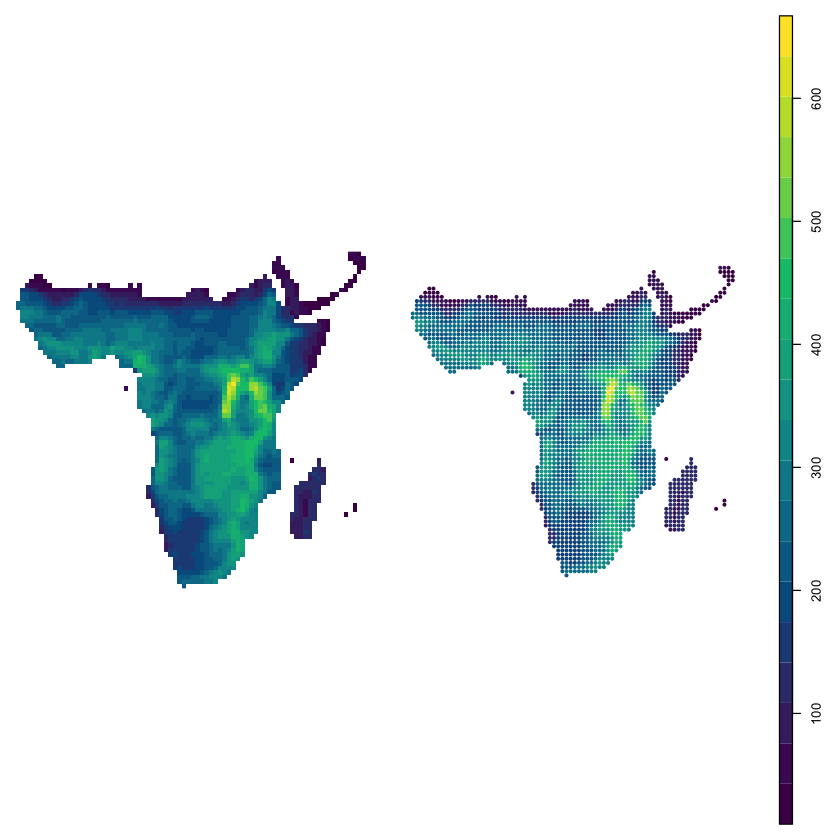

In [9]:
# Plot the richness data as point data
layout(matrix(1:3, ncol=3), widths=c(5,5,1))
plot(data_spdf['avian_richness'], col=hcl.colors(20), what='image')
plot(data_sf['avian_richness'], key.pos=NULL, reset=FALSE, main='', 
     pal=hcl.colors, cex=0.7, pch=20)
plot(data_spdf['avian_richness'], col=hcl.colors(20), what='scale')

We can also plot the variables against each other, by treating the new object as a data frame:

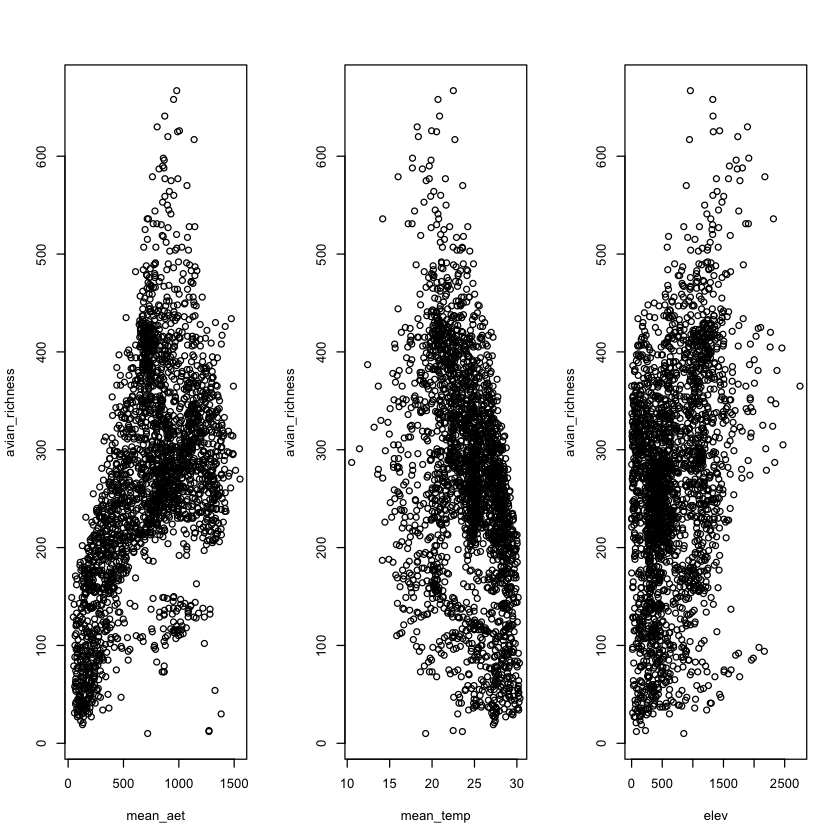

In [10]:
# Create three figures in a single panel
par(mfrow=c(1,3))
# Now plot richness as a function of each environmental variable
plot(avian_richness ~ mean_aet, data=data_sf)
plot(avian_richness ~ mean_temp, data=data_sf)
plot(avian_richness ~ elev, data=data_sf)

## Correlations and spatial data

A **correlation coefficient** is a standardised measure between -1 and 1 showing how much observations of two variables tend to co-vary. For a positive correlation, both variables tend to have high values in the same locations and low values in the same locations. Negative correlations show the opposite. Once you've calculated a correlation, you need to assess how strong that correlation is _given the amount of data you have_: it is easy to get large $r$ values in small datasets by chance.

However, correlation coefficients assume that the data points are independent and this is not true for spatial data. Nearby data points tend to be similar: if you are in a warm location, surrounding areas will also tend to be warm. One relatively simple way of removing this non-independence is to calculate the significance of tests as if you had fewer data points.

We will use this approach to  compare standard measures of correlation to spatially corrected ones. We need to load a new set of functions that implement a modification to the correlation test that accounts for spatial similarity, described in (this paper)[https://jstor.org/stable/2532039]. The modified test does not change the correlation statistic itself but calculates a new effective sample size and uses this in calculating the $F$ statistic.

In [11]:
# Use the modified.ttest function from SpatialPack
temp_corr <- modified.ttest(x=data_sf$avian_richness, y=data_sf$mean_temp, 
                            coords=st_coordinates(data_sf))
print(temp_corr)


Corrected Pearson's correlation for spatial autocorrelation

data: x and y ; coordinates: X and Y 
F-statistic: 5.1886 on 1 and 32.263 DF, p-value: 0.0295 
alternative hypothesis: true autocorrelation is not equal to 0
sample correlation: -0.3722


```{admonition} Other variables
Use this code to look at how the other explanatory variables  with bird richness. It is also worth looking at correlations between the explanatory variables!
```

## Neighbourhoods

One of the core concepts in many spatial statistical methods is the **neighbourhood** of cells. The neighbourhood of a cell defines a set of other cells that are connected to the focal cell, often with a given weight. The neighbourhood is one way of providing spatial structure to the statistical methods and there are many options for doing this. The `spdep` package provides a good guide (`vignette('nb')`) on the details, but we will look at two functions: `dnearneigh` and `knearneigh`.

### dnearneigh

We can use this function to find which cells are within a given distance of a focal point. We can also put a minimum distance to exclude nearby, but we will keep that at zero here. Working with raster data,where points are on an even grid, we can use this function to generate the **Rook** and **Queen** move neighbours. To do that we need to get the resolution of the raster and use that to set appropriate distances.

In [12]:
# Use the raster resolution as a distance
distance <- res(rich)[1]
# Give dnearneigh the coordinates of the points and the distances to use
rook <- dnearneigh(data_sf, d1=0, d2=distance)
queen <- dnearneigh(data_sf, d1=0, d2=sqrt(2) * distance)

If we look at those in a bit more details we can see that they are very similar but  - surprise! - there are more cells linked as neighbours in `queen`. Using `head` allows us to see the row numbers in our data frame that are neighbours. We can also look at the number of neighbours in each set (the *cardinality*, hence the function name `card`). If we store that in our `data_sf` data frame, we can then visualise the number of neighbours.

```{code-block} R
print(rook)
```
```{code-block} R
head(rook, n=3)
```
```{code-block} R
print(queen)
```
```{code-block} R
head(queen, n=3)
```

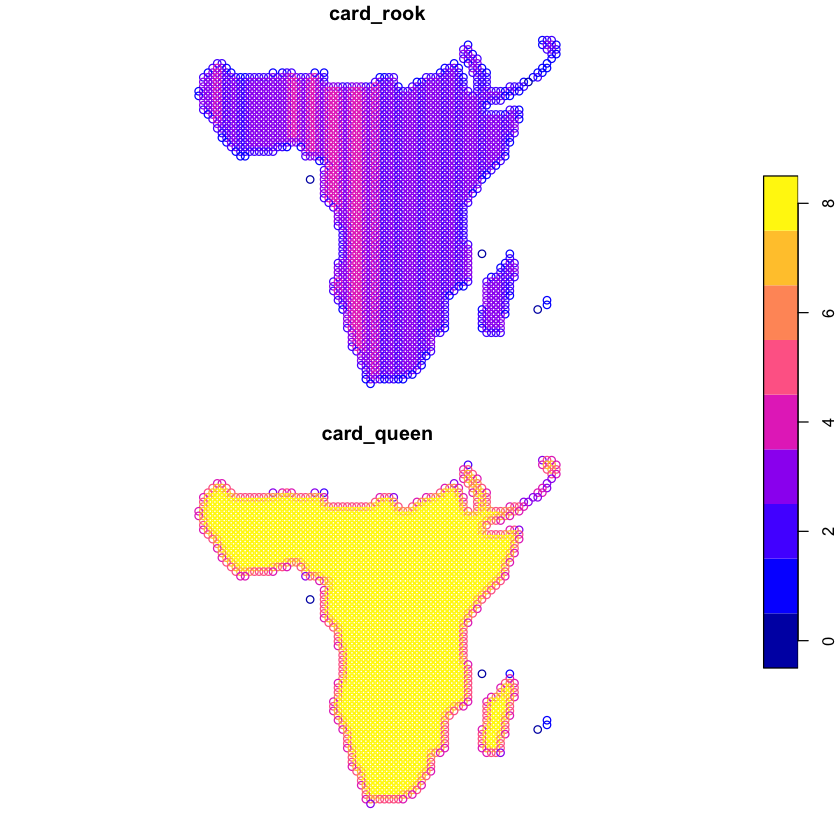

In [13]:
data_sf$card_rook <- card(rook)
data_sf$card_queen <- card(queen)
# Look at the count of rook and queen neighbours for each point
plot(data_sf[c('card_rook', 'card_queen')], key.pos=4)

That does **not** look correct - we should not be seeing those stripes in central Africa with only two or three rook neighbours. The reason for this is using _exactly_ the resolution as our distance: minor rounding differences can lead to distance based measures going wrong, so it is once again **always a good idea to plot your data and check**!

```{admonition} Fix the neighbours
A simple solution here is just to make the distance very slightly larger. Do this and recreate the `rook` and `queen` neighbours. The new version should look like the figure below.
```

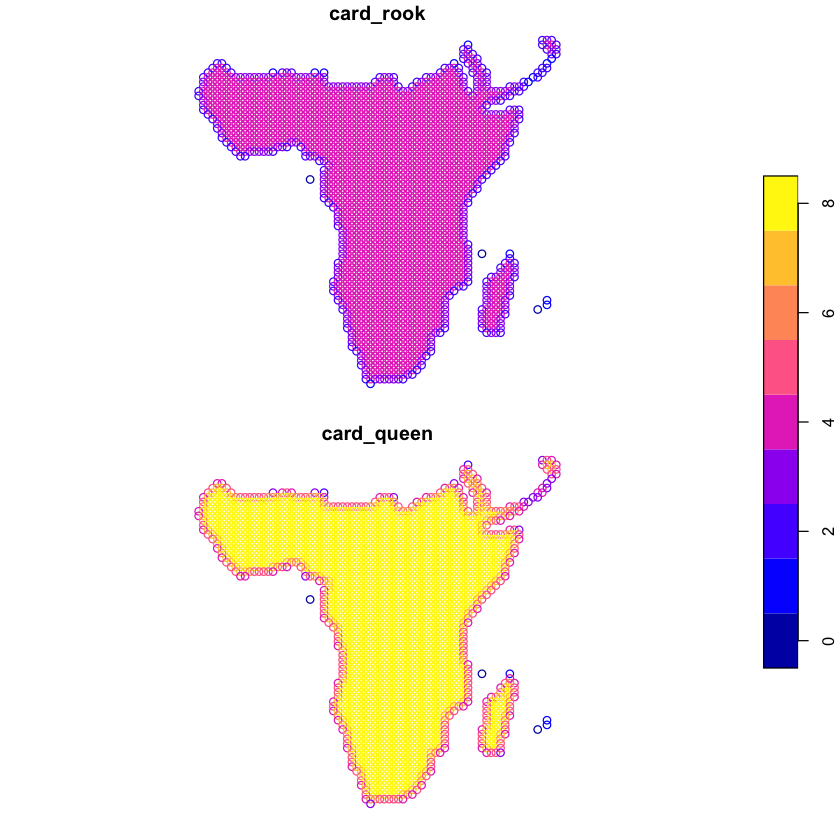

In [14]:
# Add one kilometer on to the distance
distance <- res(rich)[1] + 1
# Recreate the neighbours
rook <- dnearneigh(data_sf, d1=0, d2=distance)
queen <- dnearneigh(data_sf, d1=0, d2=sqrt(2) * distance)
data_sf$card_rook <- card(rook)
data_sf$card_queen <- card(queen)
plot(data_sf[c('card_rook', 'card_queen')], key.pos=4)

### knearneigh

One thing to not in the details of `rook` and `queen` are the bits that say:

```
3 regions with no links:
1311 1817 2204 
```

These are points that have no other point within the provided distance. These are islands: São Tomé and Principe, Comoros, and Réunion - it just happens that Mauritius falls into two cells and so has itself as a neighbour. The `knearneigh` function ensures that all points have the same number of neighbours by looking for the $k$ closest locations. You end up with a matrix

In [15]:
knn <- knearneigh(data_sf, k=8)
# We have to look at the `nn` values in `knn` to see the matrix of neighbours
head(knn$nn, n=3)

5,2,6,3,11,7,12,8
6,3,1,7,5,11,12,8
7,2,6,8,12,1,11,13


### Spatial weights

The neighbourhood functions just give us sets of neighbours, and most spatial modelling functions require **weights** to be assigned to neighbours. In `spdep`, we need to use `nb2listw` to take our plain sets of neighbours and make them into weighted neighbour lists.

In [16]:
queen <- nb2listw(queen)

ERROR: Error in nb2listw(queen): Empty neighbour sets found


That didn't work! The error message is fairly clear (for R) - we **cannot** create weighted lists for locations with no neighbours. We have two choices here: 

1. Remove the points with no neighbours - given these are isolated offshore islands, this seems reasonable.
2. Use a neighbourhood system in which they are not isolated. We already have this using `knearneigh`, but you do have to ask yourself if a model that arbitrarily links offshore islands is realistic.


Removing those isolated cells is tricky! 







There are several weighting options and choosing different weighting strategies obviously affects the resulting statistics.



## Spatial autocorrelation metrics

There are a number of statistics that quantify the level of spatial autocorrelation. We will be looking at Moran's $I$ statistic and Geary's $C$ statistic. 

* Moran's $I$ takes values between -1 and 1, with the central value of 0 showing that there is no spatial autocorrelation. Values close to -1 show strong negative autocorrelation, which is the unusual case that nearby cells have unexpectedly **different** values and values close to 1 show that nearby cells have unexpectedly **similar** values.

* Geary's $C$ scales the other way around


Spatial autocorrelation is all about saying how similar nearby points are to each other, so we first need to define 'nearby'. There are two main ways of doing this - you can choose the $k$ nearest neighbours of a point or you can choose all points within a particular distance. We will take this second approach using the `dnearneigh()` function, but for reference the function `knearneigh()` allows you to do the first one.

If we use a distance cutoff of 150 km then all cells that share an edge or a corner with a given cell will be considered its neighbour. Using chess as an analogy, this is sometimes called Queen's move connections (although it is actually like a King's move!) and the alternative where only cells sharing an edge are neighbours is called Rook's move. In the code below, we also have to set `zero.policy=TRUE`: this allows the code to ignore some checks on isolated points that have no neighbours within 150 km.

```{r moran, cache=TRUE, tidy=TRUE}
# All cells with centres closer than 150km are neighbours of a cell
neighbours <- dnearneigh(data_df, d1=0, d2=150)
# convert that to a weighted list of neighbours
neighbours.lw <- nb2listw(neighbours, zero.policy=TRUE)
# global Moran's I for avian richness
rich.moran <- moran.test(data_df$avian_richness, 
                           neighbours.lw, zero.policy=TRUE)
rich.moran
```

The `moran.test()` function gives a single value representing the overall level of spatial autocorrelation in a variable, but we can also look at local indicators of spatial autocorrelation (LISA), which can reveal areas of stronger or weaker similarity. These calculate a similar statistic but only within a window around each cell and report back the calculated value for each cell, which we can then map. Local Moran's I is still centred on zero for no spatial autocorrelation but values are not constrained between -1 and 1.

```{r lisa, cache=TRUE, dev='pdf', fig.width=5, fig.height=4, tidy=TRUE}
# Use the same neighbour definition to get local autocorrelation
rich.lisa <- localmoran(data_df$avian_richness, 
                                    neighbours.lw, zero.policy=TRUE)
# The rich.lisa results contain several variables in columns: we
# add one to our dataframe to plot it
data_df$rich_lisa <- rich.lisa[,1]
# plot the values. 
spplot(data_df, zcol='rich_lisa', col.regions=heat.colors(20), 
         scales=list(draw=TRUE))
```

<div style='background-color:lightgreen'>
* As we might predict, avian richness shows strong positive spatial autocorrelation, which seems to be particularly strong in the mountains around Lake Victoria. Try these measures out on the other variables!
</div>


# Autoregressive models

Our definition of a set of neighbours allows us to fit a spatial autoregressive (SAR) model. This is a statistical model that predicts the value of a response variable in a cell using the predictor variables and values of the response variable in neighbouring cells. This is why they are called autoregressive models: they fit the response variable partly as a response to itself.

They come in many different possible forms. This is a great paper explaining some of the different forms with some great appendices including example R code:

Kissling, W. D., & Carl, G. (2008). Spatial autocorrelation and the selection of simultaneous autoregressive models. Global Ecology and Biogeography, 17(1), 59–71. 


```{r sar, cache=TRUE, tidy=TRUE}
# Fit a simple linear model
simple_model <- lm(avian_richness ~ mean_aet + elev + mean_temp, data=data_df)
summary(simple_model)
# Fit a spatial autoregressive model: this is much slower and can take minutes to calculate
sar_model <- errorsarlm(avian_richness ~ mean_aet + elev + mean_temp, data=data_df, listw=neighbours.lw, zero.policy=TRUE)
summary(sar_model)
```

Lets look at the **predictions** of those models. We can extract the predicted values for each point and put them into our spatial data frame and then map them. 

```{r model_pred, fig.width=9, fig.height=4, dev='pdf', tidy=TRUE}
# extract the predictions from the model into the spatial data frame
data_df$simple_fit <- predict(simple_model)
data_df$sar_fit <- predict(sar_model)
# Compare those two predictions with the data
spplot(data_df, c('avian_richness','simple_fit','sar_fit'), 
        col.regions=heat.colors(20), scales=list(draw=TRUE))
```

We can also look at the **residuals** of those models -  the differences between the prediction and the actual values - to highlight where the models aren't working well. We'll manipulate the colours so negative residuals are blue and positive residuals are red.

```{r model_resid, fig.width=8, fig.height=4, dev='pdf', tidy=TRUE}
# extract the residuals from the model into the spatial data frame
data_df$simple_resid <- residuals(simple_model)
data_df$sar_resid <- residuals(sar_model)
# Create a 21 colour ramp from blue to red, centred on zero
colPal <- colorRampPalette(c('cornflowerblue', 'grey','firebrick'))
colours <- colPal(21)
breaks <- seq(-600, 600, length=21)
# plot the residuals side by side
spplot(data_df, c('simple_resid','sar_resid'), 
        col.regions=colours, at=breaks, scales=list(draw=TRUE))
```

# Correlograms

Correlograms are another way of visualising spatial autocorrelation. They show how the correlation within a variable changes as the distance between pairs of points being compared increases. To show this, we need the coordinates of the spatial data and the values of a variable at each point.

```{r correlogram, cache=TRUE, dev='pdf', fig.width=5, fig.height=4, tidy=TRUE}
# Install a missing library to calculate correlograms
library(ncf)
# extract the X and Y coordinates
data_xy <- data.frame(coordinates(data_df))
# calculate a correlogram for avian richness: a slow process!
rich.correlog <- correlog(data_xy$x, data_xy$y, data_df$avian_richness, increment=100, resamp=0)
plot(rich.correlog)
```

To explain that a bit further: we take a focal point and then make pairs of the value of that point and all other points. These pairs are assigned to bins based on how far apart the points are: the *increment* is the width of those bins. Once we've done this for all points - yes, that is a lot of pairs! - we calculate the correlations between the sets of pairs in each bin. Each bin has a mean distance among the points in that class.

We can get the significance of the correlations at each distance by resampling the data, but it is a very slow process, which is why the correlograms here have been set not to do any resampling (`resamp=0`).

We can get more control on that by creating a data frame. First, we can see that the number of pairs in a class drops off dramatically at large distances: that upswing on the right is based on few pairs, so we can generally ignore it and look at just shorter distances.

```{r correlogram_control, dev='pdf', fig.width=6, fig.height=4, tidy=TRUE}
par(mfrow=c(1,2))
# convert three key variables into a data frame
rich.correlog <- data.frame(rich.correlog[1:3])
# plot the size of the distance bins
plot(n ~ mean.of.class, data=rich.correlog, type='o')
# plot a correlogram for shorter distances
plot(correlation ~ mean.of.class, data=rich.correlog, type='o', subset=mean.of.class < 5000)
# add a horizontal  zero correlation line
abline(h=0)
```

One key use of correlograms is to assess how well models have controlled for spatial autocorrelation by looking at the correlation in the residuals. We can compare our two models like this and see how much better the SAR is at controlling for the autocorrelation in the data.

```{r correlogram_models, cache=TRUE, dev='pdf', fig.width=5, fig.height=4, tidy=TRUE}
# Calculate correlograms for the residuals in the two models
simple.correlog <- correlog(data_xy$x, data_xy$y, data_df$simple_resid, increment=100, resamp=0)
sar.correlog <- correlog(data_xy$x, data_xy$y, data_df$sar_resid, increment=100, resamp=0)
# Convert those to make them easier to plot
simple.correlog <- data.frame(simple.correlog[1:3])
sar.correlog <- data.frame(sar.correlog[1:3])

# plot a correlogram for shorter distances
plot(correlation ~ mean.of.class, data=simple.correlog, type='o', subset=mean.of.class < 5000)
# add the data for the SAR model to compare them
lines(correlation ~ mean.of.class, data=sar.correlog, type='o', subset=mean.of.class < 5000, col='red')

# add a horizontal  zero correlation line
abline(h=0)
```